# **EECS3401 Final Project**
## Our goal is to **predict the outcome of chess games and what features have the strongest influence on this outcome**

## **0 - Notebook Initialization**

In [1]:
# necessary import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/online-chess-games/chess_games.csv


In [2]:
# import the dataset
chess_data = pd.read_csv('/kaggle/input/online-chess-games/chess_games.csv')

## **1 - Exploratory Data Analysis (EDA)**
First, we must explore the dataset to see what we have to work with and what we may need to handle (null values).

In [3]:
chess_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   game_id            20058 non-null  int64 
 1   rated              20058 non-null  bool  
 2   turns              20058 non-null  int64 
 3   victory_status     20058 non-null  object
 4   winner             20058 non-null  object
 5   time_increment     20058 non-null  object
 6   white_id           20058 non-null  object
 7   white_rating       20058 non-null  int64 
 8   black_id           20058 non-null  object
 9   black_rating       20058 non-null  int64 
 10  moves              20058 non-null  object
 11  opening_code       20058 non-null  object
 12  opening_moves      20058 non-null  int64 
 13  opening_fullname   20058 non-null  object
 14  opening_shortname  20058 non-null  object
 15  opening_response   1207 non-null   object
 16  opening_variation  14398 non-null  objec

In [4]:
chess_data.shape

(20058, 17)

In [5]:
chess_data.head()

,game_id,rated,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_code,opening_moves,opening_fullname,opening_shortname,opening_response,opening_variation
0,1,False,13,Out of Time,White,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5,Slav Defense: Exchange Variation,Slav Defense,NaN,Exchange Variation
1,2,True,16,Resign,Black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,4,Nimzowitsch Defense: Kennedy Variation,Nimzowitsch Defense,NaN,Kennedy Variation
2,3,True,61,Mate,White,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,3,King's Pawn Game: Leonardis Variation,King's Pawn Game,NaN,Leonardis Variation
3,4,True,61,Mate,White,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,3,Queen's Pawn Game: Zukertort Variation,Queen's Pawn Game,NaN,Zukertort Variation
4,5,True,95,Mate,White,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,5,Philidor Defense,Philidor Defense,NaN,NaN


In [6]:
chess_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   game_id            20058 non-null  int64 
 1   rated              20058 non-null  bool  
 2   turns              20058 non-null  int64 
 3   victory_status     20058 non-null  object
 4   winner             20058 non-null  object
 5   time_increment     20058 non-null  object
 6   white_id           20058 non-null  object
 7   white_rating       20058 non-null  int64 
 8   black_id           20058 non-null  object
 9   black_rating       20058 non-null  int64 
 10  moves              20058 non-null  object
 11  opening_code       20058 non-null  object
 12  opening_moves      20058 non-null  int64 
 13  opening_fullname   20058 non-null  object
 14  opening_shortname  20058 non-null  object
 15  opening_response   1207 non-null   object
 16  opening_variation  14398 non-null  objec

In [7]:
chess_data.nunique()

game_id              20058
rated                    2
turns                  211
victory_status           4
winner                   3
time_increment         400
white_id              9438
white_rating          1516
black_id              9331
black_rating          1521
moves                18920
opening_code           365
opening_moves           23
opening_fullname      1477
opening_shortname      128
opening_response         3
opening_variation      615
dtype: int64

Just by checking the head and info of the dataset, we learned a lot of useful information:
1. the `time_increment` feature currently contains categorical not numerical values
2. Only the `opening_response` and `opening variation` features contains null values
3. Around 75% of the samples have a non-null value for the `opening_variation` feature.
4. Around  5% of the samples have a non-null value for the `opening_response` feature.

## Before we decide how to handle the dataset's features, we must first learn what they mean.

## **1.1 - Opening Features**
### In chess, the player controlling the white pieces starts first, and the sequence of starting moves they make is called an **opening**. Most openings have been given standard names and each opening may have **variations** of itself.

### Let have a closer look at the opening features alone

In [8]:
opening_features = ['opening_code', 'opening_moves', 'opening_fullname', 'opening_shortname', 'opening_response', 'opening_variation']

# non NaN 'opening_response'
# I am deliberating printing random rows instead of using head() in order to have a more diverse output since certain openings are much more common than others
chess_data[~chess_data['opening_response'].isna()][opening_features].sample(n=7, random_state=21)

,opening_code,opening_moves,opening_fullname,opening_shortname,opening_response,opening_variation
15058,C33,6,King's Gambit Accepted | Bishop's Gambit | M...,King's Gambit,Accepted,NaN
13545,A58,9,Benko Gambit Accepted | Fully Accepted Variation,Benko Gambit,Accepted,NaN
17003,D20,5,Queen's Gambit Accepted: Old Variation,Queen's Gambit,Accepted,Old Variation
10364,C21,10,Danish Gambit Accepted | Classical Defense,Danish Gambit,Accepted,NaN
8992,D31,6,Queen's Gambit Declined: Charousek (Petrosian)...,Queen's Gambit,Declined,Charousek (Petrosian) Variation
3999,D20,5,Queen's Gambit Accepted: Old Variation,Queen's Gambit,Accepted,Old Variation
12598,C34,6,King's Gambit Accepted | Fischer Defense,King's Gambit,Accepted,NaN


In [9]:
# NaN 'opening_response'
chess_data[chess_data['opening_response'].isna()][opening_features].head(3)

,opening_code,opening_moves,opening_fullname,opening_shortname,opening_response,opening_variation
0,D10,5,Slav Defense: Exchange Variation,Slav Defense,NaN,Exchange Variation
1,B00,4,Nimzowitsch Defense: Kennedy Variation,Nimzowitsch Defense,NaN,Kennedy Variation
2,C20,3,King's Pawn Game: Leonardis Variation,King's Pawn Game,NaN,Leonardis Variation


We can see that `opening_shortname` contains the standard name of the opening and the player may or may not have played a variation of this opening as evident by the `opening_variation` feature. This means that the `opening_variation` feature containing **NaN** values is a deliberate choice and not due to a lack of data. In other ways, a **NaN** `opening_variation` means that the player used the normal variation of an opening.

Some openings involve deliberately attempting to sacrifice one of the pawns in order to gain some advantage. Those openings are usually called **Gambits**. However, the opponent is the one who decides whether to accept or decline this gambit, and this is what the `opening_response` feature expresses. This feature is obviously only applicable if the opening is a gambit in the first place explaining why it has many **NaN** values.

## **1.2 - `time_increment` Feature**

- The `time` portion of `time_increment` is how many minutes **in total** each player is alotted (also known as **main time**).
- The `increment` portion of `time_increment` is how many seconds of time are added to a player's **main time** once they complete a move.

Thus, for `time_increment=15+10`, each player has 15 minutes of **main time** and is granted 10 additional seconds for each move they make.

Knowing this, we can make the following predicions:
- A long **main time** could encourage more carefully thought out moves.
- A long **increment** could encourage quicker or even rushed moves to gain more thinking time.

In this case, the categorical `time_increment` feature certainly plays a large role in deciding the outcome of a game, and it seems to reasonable to split it into two **numerical** features, `time` and `increment`.

In [10]:
# split the time_increment into 2 features, time and increment
chess_data[['time', 'increment']] = chess_data['time_increment'].str.split('+', expand=True)

# convert column type to numeric
chess_data['time'] = pd.to_numeric(chess_data['time'])
chess_data['increment'] = pd.to_numeric(chess_data['increment'])

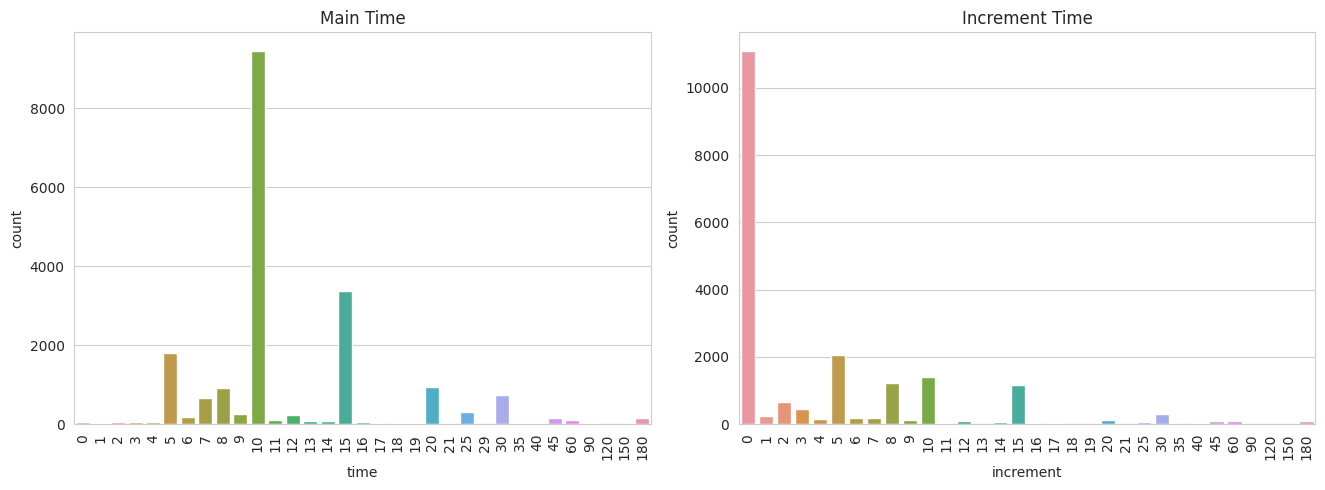

In [11]:
# Plotting `time` and `increment` count plots 

sns.set_style("whitegrid")
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.xticks(rotation=90)
sns.countplot(x='time', data=chess_data)
plt.title('Main Time')

plt.subplot(1, 3, 2)
plt.xticks(rotation=90)
sns.countplot(x='increment', data=chess_data)
plt.title('Increment Time')

plt.tight_layout()
plt.show()

## **1.3 - `victory_status`, `turns`, and `white/black_rating` Features**
We will generate the following three graphs:
1. Games outcome (`victory_status`)
2. Number of turns in games (`turns`)
3. The rating of players (`white_rating` and `black_rating`) compared with the game outcome (`winner`)

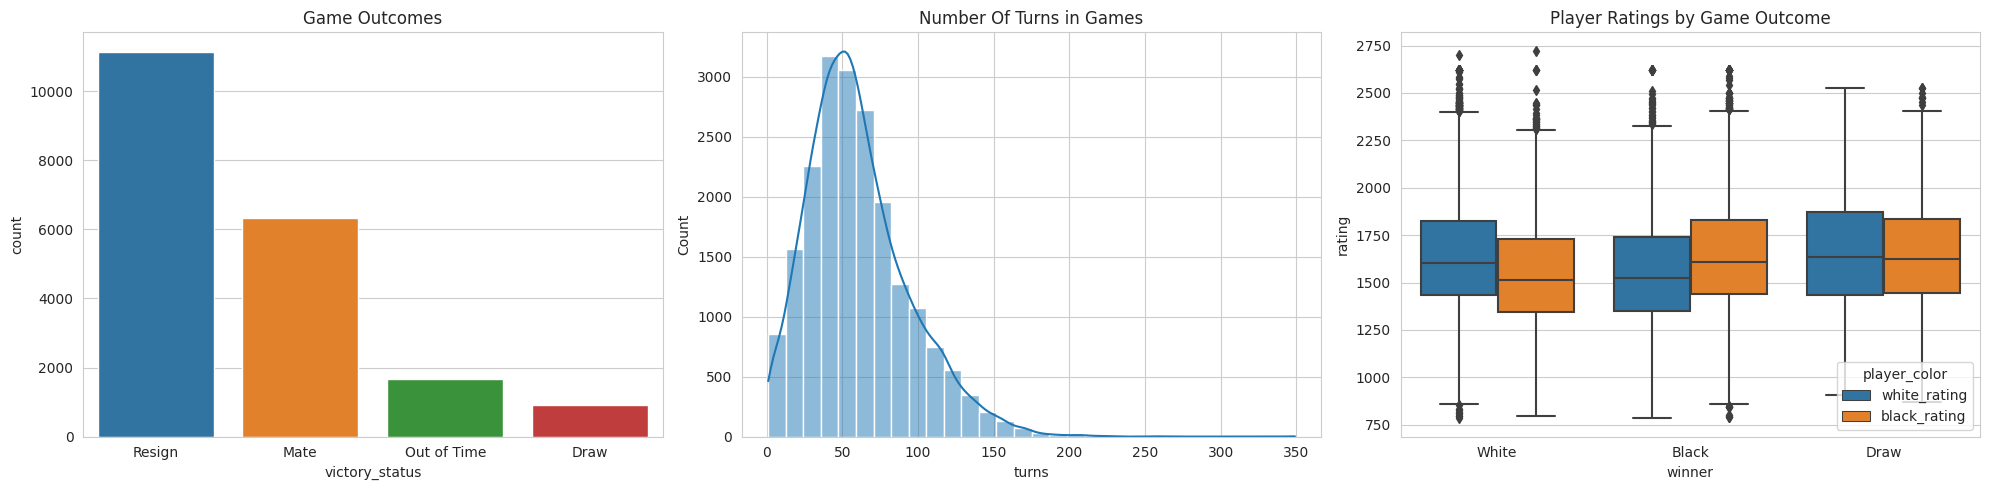

In [12]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Set style of the plots
sns.set_style("whitegrid")

# Initialize the figure
plt.figure(figsize=(20, 5))


# Distribution of game outcomes (victory_status)
plt.subplot(1, 3, 1)
sns.countplot(data=chess_data, x='victory_status', order = chess_data['victory_status'].value_counts().index)
plt.title('Game Outcomes')

# Distribution of the number of turns in games (turns)
plt.subplot(1, 3, 2)
sns.histplot(data=chess_data, x='turns', bins=30, kde=True)
plt.title('Number Of Turns in Games')


# The rating of players (white_rating and black_rating) comapred with the game outcome ('winner')
ratings_df = chess_data[['white_rating', 'black_rating', 'winner']].melt(id_vars='winner', var_name='player_color', value_name='rating')

plt.subplot(1, 3, 3)
sns.boxplot(data=ratings_df, x='winner', y='rating', hue='player_color')
plt.title('Player Ratings by Game Outcome')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

**Games Outcomes:** This bar chart shows the frequency of different victory statuses. The categrories include 'Resign' where one player resigned, 'Mate' where one player checkmates the other, 'Out of Time' where one player ran out of time, and 'Draw' where the game finished in a draw. This bar graph suggests that 'Resign' is the emost common outcome followed by 'Mate'.

**Number of Turns in Games:** This histogram represent the distibution of number of turns/moves in the game. The shape of the histogram appears to be right-skewed, which suggest that most games end with less moves, and fewer games takes large number of moves.

**Player Rating by Games Outcome:** This boxplot compares the chess rating of players based on the outcome of the game. This graph indicates that the rating of players vary with each game outcome which suggests that draws occur more frequently among players with the same rating.

## **2 - Data Cleaning**
## **2.1 - Dropping the columns we're not interested in**

In [13]:
chess_data = chess_data.drop(['game_id'], axis = 1)

# whether the game affects the players' rating (score/mmr/elo) or not
chess_data = chess_data.drop(['rated'], axis = 1)

# the full sequence of moves made
chess_data = chess_data.drop(['moves'], axis = 1)

# We want to predict whether an arbitrary player wins/loses/draws
# not if a specific player in this dataset has a higher chance of winning/losing/drawing...
chess_data = chess_data.drop(['white_id'], axis = 1)
chess_data = chess_data.drop(['black_id'], axis = 1)


# opening_code column combines this information in 1 column
chess_data = chess_data.drop(['opening_moves'], axis = 1)
chess_data = chess_data.drop(['opening_fullname'], axis = 1)
chess_data = chess_data.drop(['opening_shortname'], axis = 1)

## **2.2 - Handling NaN Values**

In [14]:
missing_values = chess_data.isnull().sum()
datatypes = chess_data.dtypes
columns = chess_data.columns

print(f'{"Feature":18} Data Type     Null Count')
print('---------------------------------------------')
for i in range(len(columns)):
    print(f'{columns[i]:18} {str(datatypes[i]):18} {missing_values[i]}')


Feature            Data Type     Null Count
---------------------------------------------
turns              int64              0
victory_status     object             0
winner             object             0
time_increment     object             0
white_rating       int64              0
black_rating       int64              0
opening_code       object             0
opening_response   object             18851
opening_variation  object             5660
time               int64              0
increment          int64              0


As we mentioned previously, `opening_response` and `opening_response` are **NaN** deliberately. Thus, methods like using the **most_common** `opening_response` or `opening_variation` to fill the **NaN** values don't make sense

We will instead:
- replace all the **NaN** values of `opening_variation` with **Standard** signifying that the standard opening was played with no variation
- replace all the **NaN** values of `opening_response` with **Not Applicable**

In [15]:
chess_data = chess_data.fillna({
    'opening_variation': 'Standard',
    'opening_response': 'Not Applicable'
})

## **2.3 - Handling duplicate rows**

In [16]:
duplicate_rows = chess_data[chess_data.duplicated()]
duplicate_rows

,turns,victory_status,winner,time_increment,white_rating,black_rating,opening_code,opening_response,opening_variation,time,increment
950,50,Resign,Black,10+0,2036,1706,A08,Not Applicable,French Variation,10,0
1794,59,Mate,White,10+0,1171,1432,A29,Not Applicable,King's English Variation,10,0
1830,113,Mate,White,10+0,1403,1364,C00,Not Applicable,Steinitz Attack,10,0
2554,78,Mate,Black,15+0,1309,1393,B01,Not Applicable,Mieses-Kotroc Variation,15,0
2556,51,Mate,White,15+0,1393,1309,D04,Not Applicable,Colle System,15,0
...,...,...,...,...,...,...,...,...,...,...,...
20013,95,Resign,Black,45+45,2094,2228,C60,Not Applicable,Fianchetto Defense,45,45
20014,109,Draw,Draw,45+45,2229,2220,C54,Not Applicable,Classical Variation,45,45
20015,42,Resign,Black,7+30,2162,2214,E11,Not Applicable,Wade-Smyslov Variation,7,30
20016,102,Resign,Black,7+30,2236,2148,B06,Not Applicable,Standard,7,30


While one reading this may be tempted to say that the duplicate rows are actually meaningful data signifying that more than one player using the same game strategy reached the same game outcome, two features reject this hypothesis, `white_rating` and `black_rating`.

####  It is very unlikely that in 2 games, players with identical `white_rating` and `black_rating` played the same exact opening, reached the same game outcome, and **in the same number of turns**.
Hence, these duplicate rows must be the result of some mistake in data collection and not meaningful data, so we will drop them.

In [17]:
# Drop duplicates
chess_data = chess_data.drop_duplicates()

chess_data.shape

(19110, 11)

## **3 - Data Preprocessing & Columnn Transformation**
Data Pipeline's for **numerical** and **categorical** columns using StandardScaler for integers and OneHotEncoder for categorical values that we have specified to be preprocessed

## **3.1 - Data Transformers and Pipelines**

In [18]:
# necessary library imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [19]:
# Separate features and target variable
X = chess_data.drop(['winner'], axis=1)
y = chess_data['winner']

# Define numerical and categorical features
num_features = ['turns', 'white_rating', 'black_rating', 'time', 'increment']
cat_features = ['opening_code']

# Create transformers for numerical and categorical features
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Use ColumnTransformer to apply transformers to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['turns', 'white_rating', 'black_rating',
                                  'time', 'increment']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['opening_code'])])

# Model Pipelines
Create Specific Pipelines for the selected machine learning algorithms:


<u>Random Forest (RF): </u>
<br>
Random Forest is an ensemble learning method used for both classification and regression tasks. It constructs multiple decision trees and combines their predictions.
<br>


<u>Gradient Boosting (GB): </u>
<br>
Gradient Boosting is also an ensemble learning method that builds a series of weak learners (typically decision trees) sequentially. It focuses on correcting errors made by the previous models.
<br>


<u>Logistics Regression (LR): </u>
<br>
Logistic Regression is a binary classification algorithm used to predict the probability that an instance belongs to a particular class (typically 0 or 1).
<br>
<br>
<br>
At the end of this block we split the data 80-20 for training and testing

## **3.2 - Machine Learning Model Pipelines**

In [20]:
# Create the pipeline with the preprocessing step and the classifier
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RandomForestClassifier(random_state=42))])

gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', GradientBoostingClassifier(random_state=42))])

lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', LogisticRegression(random_state=42))])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  **4 - Algorithm Evaluation's**

In [21]:
from sklearn.metrics import accuracy_score, classification_report

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Train and evaluate Gradient Boosting
gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

print("\nGradient Boosting Accuracy:", accuracy_gb)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print("Logistic Regression Accuracy:", accuracy_lr)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

Random Forest Accuracy: 0.619570905285191
Random Forest Classification Report:
              precision    recall  f1-score   support

       Black       0.61      0.63      0.62      1766
        Draw       0.18      0.01      0.02       182
       White       0.63      0.67      0.65      1874

    accuracy                           0.62      3822
   macro avg       0.47      0.44      0.43      3822
weighted avg       0.60      0.62      0.61      3822


Gradient Boosting Accuracy: 0.6881214024071167
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

       Black       0.69      0.69      0.69      1766
        Draw       0.21      0.02      0.04       182
       White       0.69      0.75      0.72      1874

    accuracy                           0.69      3822
   macro avg       0.53      0.49      0.48      3822
weighted avg       0.67      0.69      0.67      3822



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.6224489795918368
Logistic Regression Classification Report:
              precision    recall  f1-score   support

       Black       0.62      0.60      0.61      1766
        Draw       0.67      0.02      0.04       182
       White       0.62      0.70      0.66      1874

    accuracy                           0.62      3822
   macro avg       0.64      0.44      0.44      3822
weighted avg       0.62      0.62      0.61      3822



**Random Forest Accuracy: <u>62.0%</u>
<br>
Gradient Boosting Accuracy: <u>68.8%</u>
<br>
Logistic Regression Accuracy: <u>62.2%</u>**



<h2>Best Performing Algorithm</h2>
Based on the above 3 learning algorithms, Gradient Boosting (GB) algorithm is the most accurate in predicting the outcome of a chess game with our dataset, hence we use GB as our best-performing algorithm.

#  **5 - Graphs of GB**

## **5.1 - Confusion Matrix**

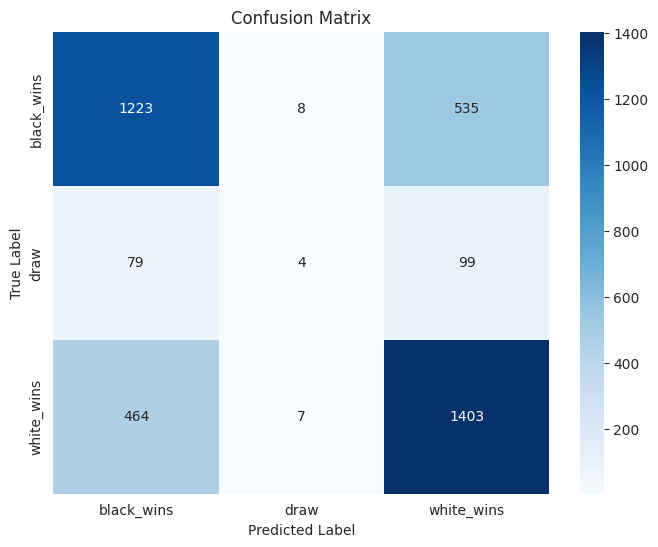

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['black_wins', 'draw', 'white_wins']
# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.show()


<h3>Matrix Results:</h3>


1. **Class "black_wins":**
   - True Positive (TP): 1223 (Predicted as Black Wins, and it is Black Wins)
   - False Positive (FP): 8 (Predicted as Black Wins, but it is not Black Wins)
   - False Negative (FN): 535 (Not predicted as Black Wins, but it is Black Wins)

2. **Class "draw":**
   - False Negative (FN): 79 (Not predicted as Draw, but it is Draw)
   - True Negative (TN): 4 (Predicted as not Draw, and it is not Draw)
   - False Positive (FP): 99 (Predicted as Draw, but it is not Draw)

3. **Class "white_wins":**
   - False Positive (FP): 464 (Predicted as White Wins, but it is not White Wins)
   - False Negative (FN): 7 (Not predicted as White Wins, but it is White Wins)
   - True Positive (TP): 1403 (Predicted as White Wins, and it is White Wins)

## **5.2 - Learning Curve**

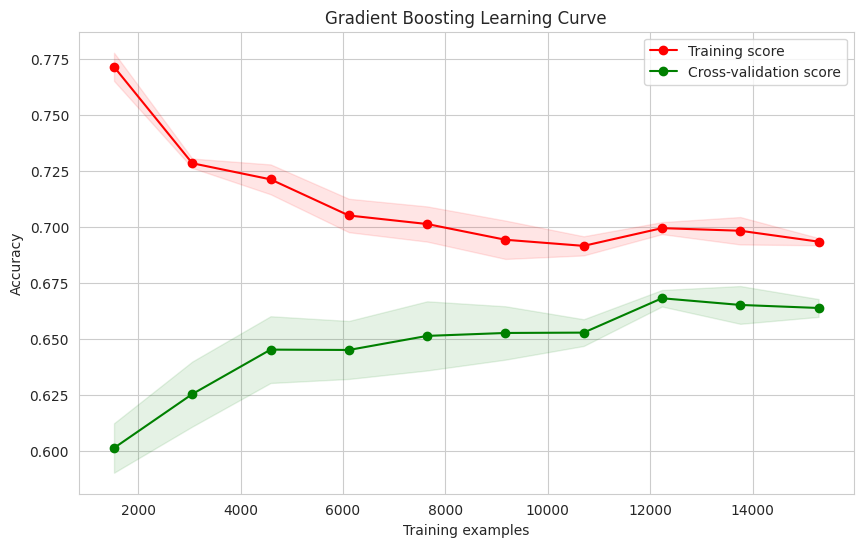

In [23]:
from sklearn.model_selection import learning_curve

# Assuming 'gb_pipeline' is your Gradient Boosting pipeline
# 'X' and 'y' are your features and target variable
train_sizes, train_scores, validation_scores = learning_curve(
    gb_pipeline, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy', random_state=42)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.title("Gradient Boosting Learning Curve")
plt.legend(loc="best")
plt.show()


<b>Interpretation:</b>

- In the beginning, with a small training set (1000), the model performs well on the training data but poorly on the cross-validation data. This suggests that the model might be overfitting to the small amount of training data.
- As the training set size increases, the training score decreases, and the cross-validation score increases, indicating that the model is generalizing better to new data. This is a positive sign, suggesting that providing more data helps the model generalize better.
- The convergence of the two curves suggests that increasing the training set size beyond a certain point (around 12200) may not significantly improve model performance. The small gap between the two curves indicates that the model is not overfitting, and there is a good balance between bias and variance.

# **5.3 - Feature Importance**
## **5.3a - Extracting Feature Importance**

In [24]:
# Extract numerical feature names
num_feature_names = (gb_pipeline.named_steps['preprocessor']
                     .named_transformers_['num']
                     .named_steps['scaler']
                     .get_feature_names_out(input_features=num_features))

# Extract categorical feature names after one-hot encoding
cat_feature_names = (gb_pipeline.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(input_features=cat_features))

# Combine numerical and categorical feature names
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# Create a DataFrame to associate feature names with their importance scores from the GB classifier
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': gb_pipeline.named_steps['classifier'].feature_importances_})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.head(30)

,Feature,Importance
0,turns,0.363295
1,white_rating,0.299669
2,black_rating,0.277611
3,time,0.006572
5,opening_code_A00,0.004300
4,increment,0.003122
177,opening_code_C22,0.002472
94,opening_code_B20,0.002235
75,opening_code_B00,0.002009
359,opening_code_E92,0.001373


As we can see above there are many features which are based on combinations of opening_code's, and they all contribute extremely litle importance, which is why we will drop all of the opening_code features to focus on main factors

## **5.3b - Dropping Unimportance Features**

In [25]:
# Remove rows where the value in the "opening_code" column starts with "opening_code"
feature_importance_df = feature_importance_df[~feature_importance_df['Feature'].str.startswith('opening_code')]
feature_importance_df.head(15)

,Feature,Importance
0,turns,0.363295
1,white_rating,0.299669
2,black_rating,0.277611
3,time,0.006572
4,increment,0.003122


Now we only have significant features, and we will plot the graph

## **5.3c - Plotting Feature Importance**

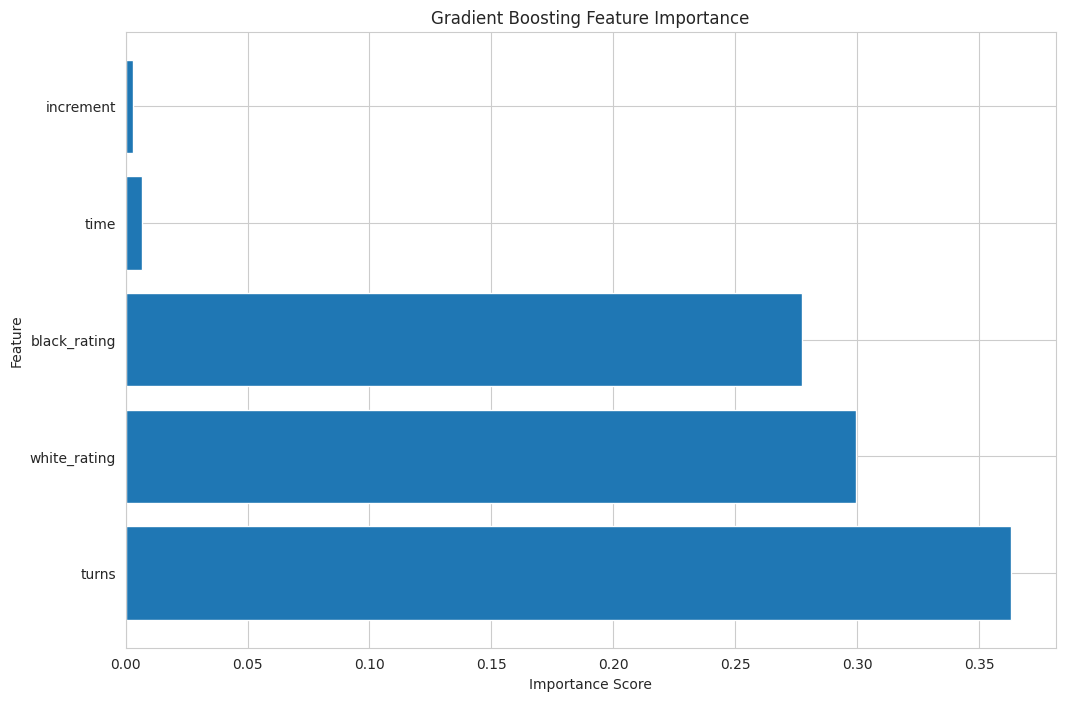

In [26]:
# Plot the feature importance graph
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Gradient Boosting Feature Importance')
plt.show()

As a result we can see that the main important features are `"white_rating", "turns", "black_rating"` <br>
then there are also some features which are somewhat important within 1%